## QUERY

In [1]:
# usage example (the mysql detail already defined)
# simple query
query_order_garden_care = """
SELECT
  order_garden_care_detail.id AS id,
  order_garden_care_detail.id_order_garden_care AS id_order_garden_care,
  order_garden_care_detail.status AS status,
  order_garden_care.id_user,
  order_garden_care.price,
  promo_code.code ,
  category_size.size ,
  garden_care.care_count AS jumlah_perawatan,
  garden_care.manpower AS manpower_required,
  order_garden_care.address,
  address_components.address_componentable_id ,
  CAST(address_components.latitude AS FLOAT) AS lat,
  CAST(address_components.longitude AS FLOAT) AS lng,
  order_garden_care.created_at AS order_date 
FROM
  order_garden_care_detail
  JOIN order_garden_care ON order_garden_care_detail.id_order_garden_care = order_garden_care.id
  LEFT JOIN category_size ON order_garden_care.id_category_size = category_size.id_category
  LEFT JOIN promo_code ON order_garden_care.id_promo_code = promo_code.id_promo 
  LEFT JOIN garden_care ON garden_care.id = order_garden_care.id_garden_care
  LEFT JOIN address_components ON order_garden_care.id = address_components.address_componentable_id
  LEFT JOIN user ON order_garden_care.id_user = user.id_user
WHERE
  (
    order_garden_care_detail.maintenance_schedule IS NULL
  )
  AND (
    (order_garden_care_detail.status <> 'expired')
    OR (order_garden_care_detail.status IS NULL)
  )
  AND address_components.address_componentable_type LIKE '%OrderGardenCare'
GROUP BY
  order_garden_care_detail.id_order_garden_care,
  order_garden_care_detail.status,
  order_garden_care.id_user,
  garden_care.care_count,
  garden_care.manpower,
  category_size.size,
  order_garden_care.address,
  order_garden_care.price,
  order_garden_care.id_promo_code,
  address_components.latitude,
  address_components.longitude,
  order_garden_care.created_at
"""

## Import Function

In [2]:
from functions.database_load import *
from functions.cleaning import * 
from functions.utils import *
from functions.clustering import *
from functions.neighbors import *
from functions.visualization import *

#### Reload/ update function

In [3]:
# from importlib import reload
# import functions.utils
# reload(functions.utils)

## Mengambil Data Order Garden Care

In [4]:
# fetch data
df_ogc = fetch_data(query_order_garden_care)

In [5]:
df_ogc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id                        101 non-null    int64         
 1   id_order_garden_care      101 non-null    int64         
 2   status                    101 non-null    object        
 3   id_user                   101 non-null    int64         
 4   price                     101 non-null    float64       
 5   code                      98 non-null     object        
 6   size                      101 non-null    object        
 7   jumlah_perawatan          101 non-null    int64         
 8   manpower_required         101 non-null    int64         
 9   address                   101 non-null    object        
 10  address_componentable_id  101 non-null    int64         
 11  lat                       101 non-null    float64       
 12  lng                   

### Menghapus data id yang tidak terpakai 

In [6]:
#  menghapus id yang tidak terpakai untuk analisis
ids_to_remove= [921, 699, 969, 981, 1025, 1256, 1302]
df_ogc_new = remove_ids_from_dataframe(df_ogc, column_name="id", ids_to_remove=ids_to_remove)

## Missing Values

In [7]:
#  cek missing values
cek_missing_values(df_ogc_new)

id                          0
id_order_garden_care        0
status                      0
id_user                     0
price                       0
code                        3
size                        0
jumlah_perawatan            0
manpower_required           0
address                     0
address_componentable_id    0
lat                         0
lng                         0
order_date                  0
dtype: int64

In [8]:
# input code promo yang null dengan nilai N/A
fill_missing_values(df_ogc_new, column_name="code", fill_value="N/A").head()

,id,id_order_garden_care,status,id_user,price,code,size,jumlah_perawatan,manpower_required,address,address_componentable_id,lat,lng,order_date
0,105,28,paid,1186,0.0,dokumentasigc,11-20m<sup>2</sup>,3,1,Semanggi,28,-6.22111,106.814,2024-07-02 10:18:44
1,598,88,paid,1268,0.0,dokumentasigc,41-50m<sup>2</sup>,12,2,"Jl Palem VI/35, Petukangan Utara, Jakarta Selatan",88,-6.22585,106.757,2024-07-04 11:54:30
2,626,103,paid,1329,1049500.0,SUBS50,11-20m<sup>2</sup>,6,1,"Jl. Canary Timur 2 No. 3 (The Springs, Cluster...",103,-6.26852,106.642,2024-07-25 14:33:54
3,632,104,paid,1353,1999500.0,SUBS50,11-20m<sup>2</sup>,12,1,Perumahan Graha Mirai Cluster Hikari Blok H No...,104,-6.38129,107.117,2024-07-26 09:17:45
4,648,105,paid,1356,1549500.0,SUBS50,21-30m<sup>2</sup>,6,2,"Jl Cisanggiri III No.18\r\nKebayoran Baru, Jak...",105,-6.24165,106.813,2024-07-27 14:07:02


In [9]:
# Split numeric and object data
df_ogc_num = df_ogc_new.select_dtypes(include=['int64', 'float64'])

In [10]:
#  preprocess data (drop missing values dan scaling)
preprocess_data(df_ogc_num)

,id,id_order_garden_care,id_user,price,jumlah_perawatan,manpower_required,address_componentable_id,lat,lng
0,105,28,1186,0.0,3,1,28,-6.22111,106.814
1,598,88,1268,0.0,12,2,88,-6.22585,106.757
2,626,103,1329,1049500.0,6,1,103,-6.26852,106.642
3,632,104,1353,1999500.0,12,1,104,-6.38129,107.117
4,648,105,1356,1549500.0,6,2,105,-6.24165,106.813
...,...,...,...,...,...,...,...,...,...
96,1424,278,1349,0.0,1,1,278,-6.28399,106.799
97,1426,279,1349,0.0,12,1,279,-6.19445,106.823
98,1449,287,1937,0.0,12,1,287,-6.31348,106.937
99,1473,289,1451,0.0,6,1,289,-6.16404,106.903


In [11]:
# find outliers
for col in df_ogc_num:
        values = df_ogc_num[col].sort_values().values.tolist()
        outliers = find_outlier(values)
        outlier_count = len(outliers.split(', ')) - 1  # Split string and count
        outlier_percent = (outlier_count / len(values)) * 100
        print(f"Outliers detected in '{col}': {outlier_count} ({outlier_percent:.2f}%)")

Outliers detected in 'id': 1 (1.06%)
Outliers detected in 'id_order_garden_care': 1 (1.06%)
Outliers detected in 'id_user': 3 (3.19%)
Outliers detected in 'price': 6 (6.38%)
Outliers detected in 'jumlah_perawatan': 0 (0.00%)
Outliers detected in 'manpower_required': 0 (0.00%)
Outliers detected in 'address_componentable_id': 1 (1.06%)
Outliers detected in 'lat': 1 (1.06%)
Outliers detected in 'lng': 3 (3.19%)


## Clustering Order Garden Care

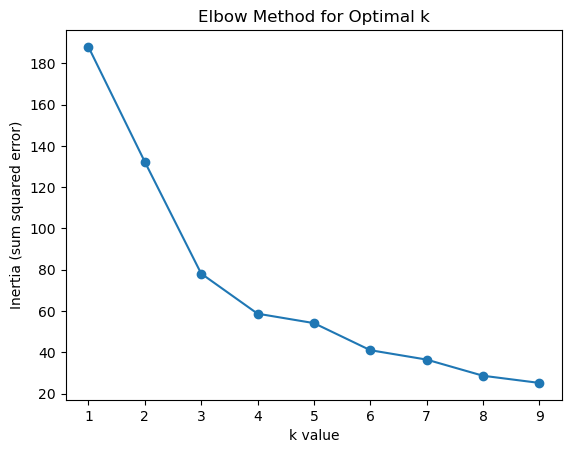

Inertia values for k=1 to 9: [188.00000000000003, 132.3081212435126, 78.13685786820817, 58.7053265948956, 54.13422640849154, 41.00943395012829, 36.44935209893243, 28.622751967610778, 25.14300326961963]


In [12]:
# tentukan kolom untuk cluster
feature_cols = ['lat', 'lng']
# Hitung inertia
inertia_values = calculate_inertia(df_ogc_new, feature_cols)

# print inertia
print("Inertia values for k=1 to 9:", inertia_values)

In [13]:
# menentukan cluster dan menambahkan kolom cluster pada data order garden care
perform_clustering(df_ogc_new, feature_cols, n_clusters=7, max_iter=1000)

,id,id_order_garden_care,status,id_user,price,code,size,jumlah_perawatan,manpower_required,address,address_componentable_id,lat,lng,order_date,cluster
0,105,28,paid,1186,0.0,dokumentasigc,11-20m<sup>2</sup>,3,1,Semanggi,28,-6.22111,106.814,2024-07-02 10:18:44,0
1,598,88,paid,1268,0.0,dokumentasigc,41-50m<sup>2</sup>,12,2,"Jl Palem VI/35, Petukangan Utara, Jakarta Selatan",88,-6.22585,106.757,2024-07-04 11:54:30,1
2,626,103,paid,1329,1049500.0,SUBS50,11-20m<sup>2</sup>,6,1,"Jl. Canary Timur 2 No. 3 (The Springs, Cluster...",103,-6.26852,106.642,2024-07-25 14:33:54,3
3,632,104,paid,1353,1999500.0,SUBS50,11-20m<sup>2</sup>,12,1,Perumahan Graha Mirai Cluster Hikari Blok H No...,104,-6.38129,107.117,2024-07-26 09:17:45,2
4,648,105,paid,1356,1549500.0,SUBS50,21-30m<sup>2</sup>,6,2,"Jl Cisanggiri III No.18\r\nKebayoran Baru, Jak...",105,-6.24165,106.813,2024-07-27 14:07:02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1424,278,paid,1349,0.0,dokumentasigc,11-20m<sup>2</sup>,1,1,Nama Klien: Ruben onsu/ Sarwendah\nAlamat : Jl...,278,-6.28399,106.799,2024-11-10 17:25:39,1
97,1426,279,paid,1349,0.0,dokumentasigc,11-20m<sup>2</sup>,12,1,DKI Jakarta,279,-6.19445,106.823,2024-11-10 17:30:09,0
98,1449,287,paid,1937,0.0,dokumentasigc,11-20m<sup>2</sup>,12,1,"alia residence, jln. alia 6 no. 22 Jatimelati ...",287,-6.31348,106.937,2024-11-12 11:22:32,4
99,1473,289,paid,1451,0.0,dokumentasigc,<10m<sup>2</sup>,6,1,Cluster nara village Jalan boulevard no.17,289,-6.16404,106.903,2024-11-12 14:25:56,0


In [14]:
calculate_nearest_neighbors(
    df_ogc_new,
    lat_col='lat',        # Nama kolom latitude
    lng_col='lng',        # Nama kolom longitude
    id_col='id',          # Nama kolom ID unik
    n_neighbors=3,        # Jumlah tetangga terdekat
    max_distance=10000    # Jarak maksimum dalam meter
)

,id,id_order_garden_care,status,id_user,price,code,size,jumlah_perawatan,manpower_required,address,address_componentable_id,lat,lng,order_date,cluster,neighbors,neighbor_distances,valid_neighbors,valid_distances
0,105,28,paid,1186,0.0,dokumentasigc,11-20m<sup>2</sup>,3,1,Semanggi,28,-6.22111,106.814,2024-07-02 10:18:44,0,"[105, 1369, 1273]","[0.0, 0.0, 0.015208800084153184]","[105, 1369, 1273]","[0.0, 0.0, 1682.3251674120347]"
1,598,88,paid,1268,0.0,dokumentasigc,41-50m<sup>2</sup>,12,2,"Jl Palem VI/35, Petukangan Utara, Jakarta Selatan",88,-6.22585,106.757,2024-07-04 11:54:30,1,"[598, 1031, 757]","[0.0, 0.00932952303176105, 0.00932952303176105]","[598, 1031, 757]","[0.0, 1032.2791218934954, 1032.2791218934954]"
2,626,103,paid,1329,1049500.0,SUBS50,11-20m<sup>2</sup>,6,1,"Jl. Canary Timur 2 No. 3 (The Springs, Cluster...",103,-6.26852,106.642,2024-07-25 14:33:54,3,"[626, 872, 897]","[0.0, 0.01826407402525223, 0.020780204522571247]","[626, 872, 897]","[0.0, 2020.2576762257936, 2298.453920721123]"
3,632,104,paid,1353,1999500.0,SUBS50,11-20m<sup>2</sup>,12,1,Perumahan Graha Mirai Cluster Hikari Blok H No...,104,-6.38129,107.117,2024-07-26 09:17:45,2,"[632, 951, 930]","[0.0, 0.07608562610637913, 0.1282342391875163]","[632, 951]","[0.0, 8417.422269058583]"
4,648,105,paid,1356,1549500.0,SUBS50,21-30m<sup>2</sup>,6,2,"Jl Cisanggiri III No.18\r\nKebayoran Baru, Jak...",105,-6.24165,106.813,2024-07-27 14:07:02,1,"[648, 1273, 1244]","[0.0, 0.011513400887658266, 0.013483931177521582]","[648, 1273, 1244]","[0.0, 1273.667620124709, 1492.108136461525]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1424,278,paid,1349,0.0,dokumentasigc,11-20m<sup>2</sup>,1,1,Nama Klien: Ruben onsu/ Sarwendah\nAlamat : Jl...,278,-6.28399,106.799,2024-11-10 17:25:39,1,"[1424, 1371, 1293]","[0.0, 0.006942398720904156, 0.008703614191813222]","[1424, 1371, 1293]","[0.0, 767.7528038757646, 962.6371242176327]"
97,1426,279,paid,1349,0.0,dokumentasigc,11-20m<sup>2</sup>,12,1,DKI Jakarta,279,-6.19445,106.823,2024-11-10 17:30:09,0,"[1426, 925, 1226]","[0.0, 0.007777666745243527, 0.010581663385314499]","[1426, 925, 1226]","[0.0, 860.6585918928907, 1171.0120964421687]"
98,1449,287,paid,1937,0.0,dokumentasigc,11-20m<sup>2</sup>,12,1,"alia residence, jln. alia 6 no. 22 Jatimelati ...",287,-6.31348,106.937,2024-11-12 11:22:32,4,"[1449, 1062, 1366]","[0.0, 0.011200000000000543, 0.01423435632544802]","[1449, 1062, 1366]","[0.0, 1238.5820249024378, 1574.5816645366801]"
99,1473,289,paid,1451,0.0,dokumentasigc,<10m<sup>2</sup>,6,1,Cluster nara village Jalan boulevard no.17,289,-6.16404,106.903,2024-11-12 14:25:56,0,"[1473, 1207, 1101]","[0.0, 0.030265823960373684, 0.0354039545813749]","[1473, 1207, 1101]","[0.0, 3349.4514521017554, 3917.5375652881694]"


## Analisis dan Visualization

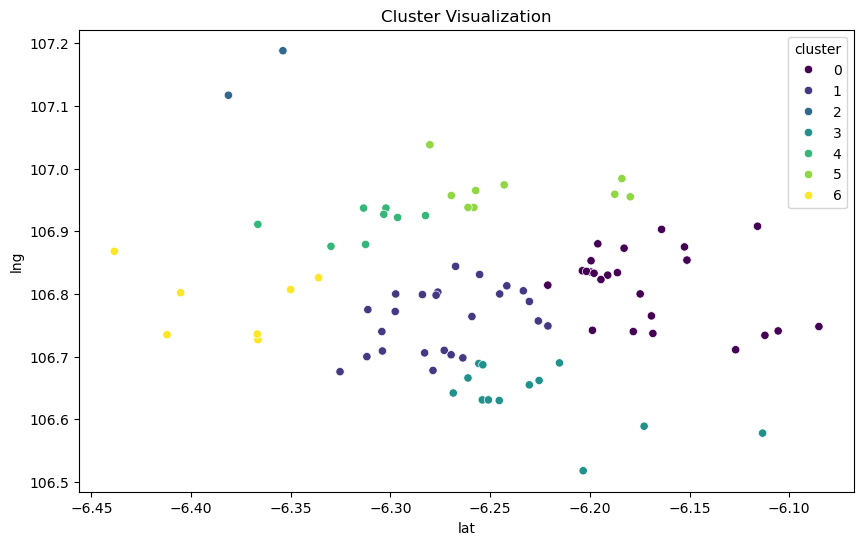

In [24]:
# visualization cluster menggunakan scater plot
visualize_clusters(
    data=df_ogc_new, 
    x_col= 'lat',
    y_col= 'lng', 
    cluster_col="cluster")

In [15]:
# Menghitung jumlah sales count per cluster
sales_count_per_cluster = df_ogc_new.groupby('cluster').size().reset_index(name='sales_count')

# Mengurutkan hasil dari sales count tertinggi ke terendah
sales_count_per_cluster = sales_count_per_cluster.sort_values(by='sales_count', ascending=False)

# Menampilkan hasil
print(sales_count_per_cluster)

   cluster  sales_count
0        0           29
1        1           25
3        3           13
5        5           10
4        4            8
6        6            7
2        2            2


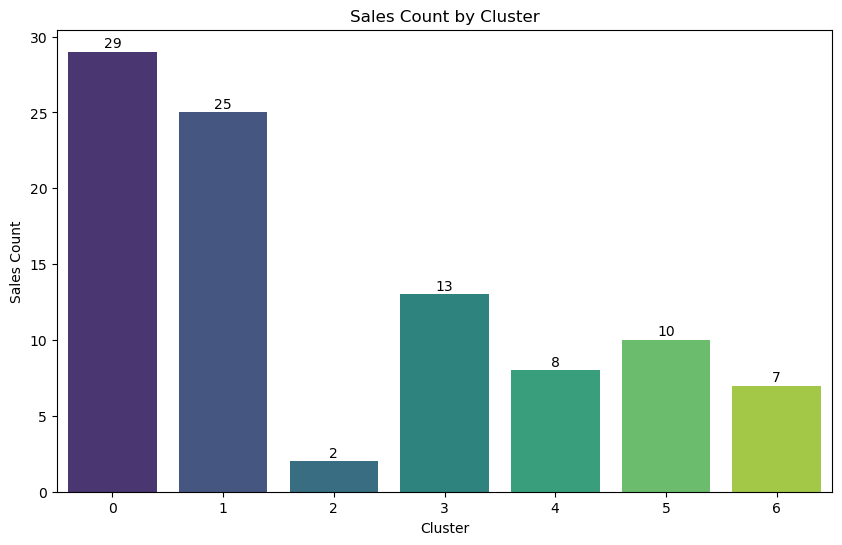

In [16]:
# visualization sales count by cluster
# barplot_visualization(data, x_col, y_col, title, xlabel, ylabel) -> function yang digunakan 
barplot_visualization(
    data=sales_count_per_cluster, 
    x_col='cluster', 
    y_col='sales_count',
    title='Sales Count by Cluster',
    xlabel='Cluster',
    ylabel='Sales Count'
)

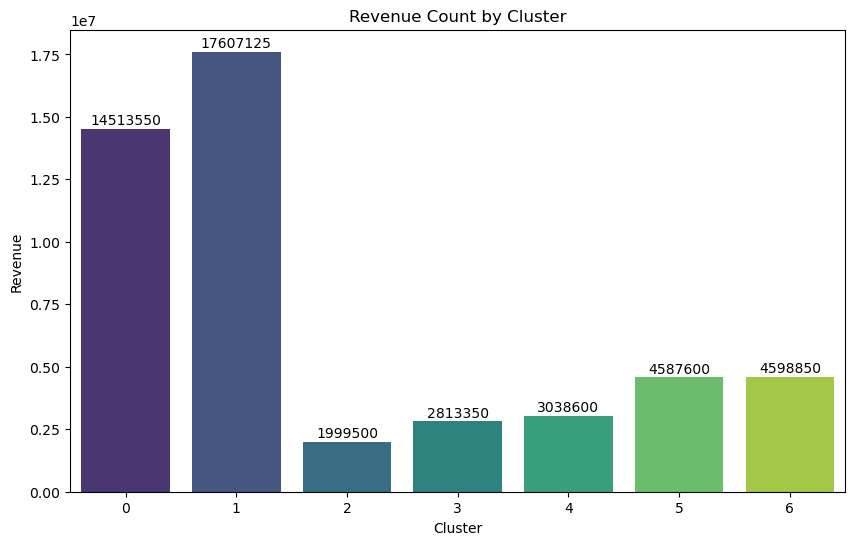

In [17]:
# Menghitung total revenue per cluster
revenue_per_cluster = df_ogc_new.groupby('cluster')['price'].sum().reset_index(name='revenue')

# Mengurutkan hasil dari revenue tertinggi ke terendah
revenue_per_cluster = revenue_per_cluster.sort_values(by='revenue', ascending=False)

# barplot_visualization(data, x_col, y_col, title, xlabel, ylabel) -> function yang digunakan 
barplot_visualization(
    data=revenue_per_cluster, 
    x_col='cluster', 
    y_col='revenue',
    title='Revenue Count by Cluster',
    xlabel='Cluster',
    ylabel='Revenue'
)

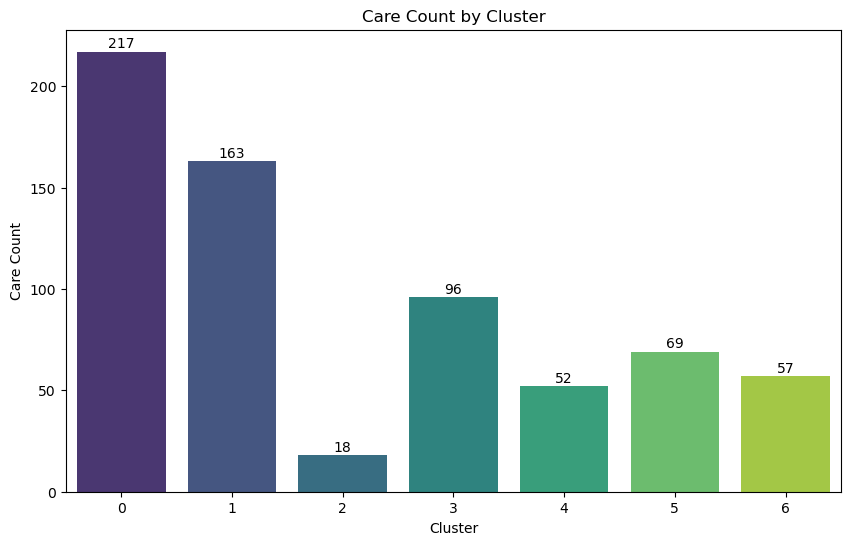

In [18]:
# visualisasi jumlah perawatan per cluster
cluster_care_count = df_ogc_new.groupby('cluster')['jumlah_perawatan'].sum().reset_index()
cluster_care_count = cluster_care_count.sort_values(by='jumlah_perawatan', ascending=False)

# barplot_visualization(data, x_col, y_col, title, xlabel, ylabel) -> function yang digunakan 
barplot_visualization(
    data=cluster_care_count, 
    x_col='cluster', 
    y_col='jumlah_perawatan',
    title='Care Count by Cluster',
    xlabel='Cluster',
    ylabel='Care Count'
)

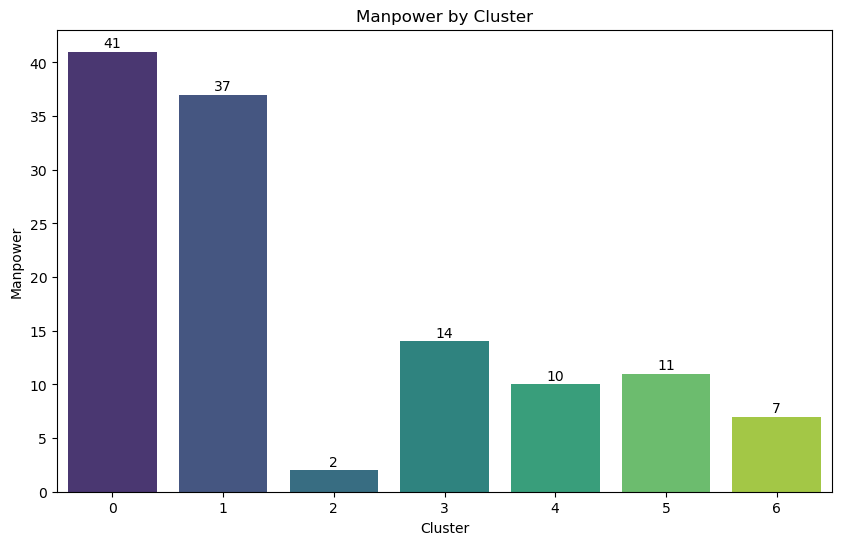

In [19]:
# visualisasi manpower per cluster
manpower_per_cluster = df_ogc_new.groupby('cluster')['manpower_required'].sum().reset_index()
manpower_per_cluster = manpower_per_cluster.sort_values(by='manpower_required', ascending=False)

# barplot_visualization(data, x_col, y_col, title, xlabel, ylabel) -> function yang digunakan 
barplot_visualization(
    data=manpower_per_cluster, 
    x_col='cluster', 
    y_col='manpower_required',
    title='Manpower by Cluster',
    xlabel='Cluster',
    ylabel='Manpower'
)

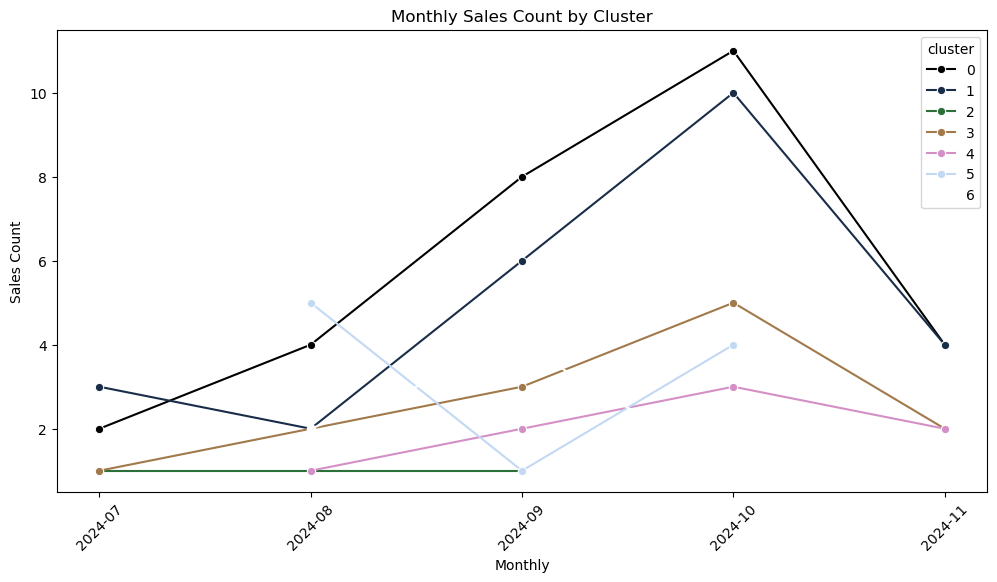

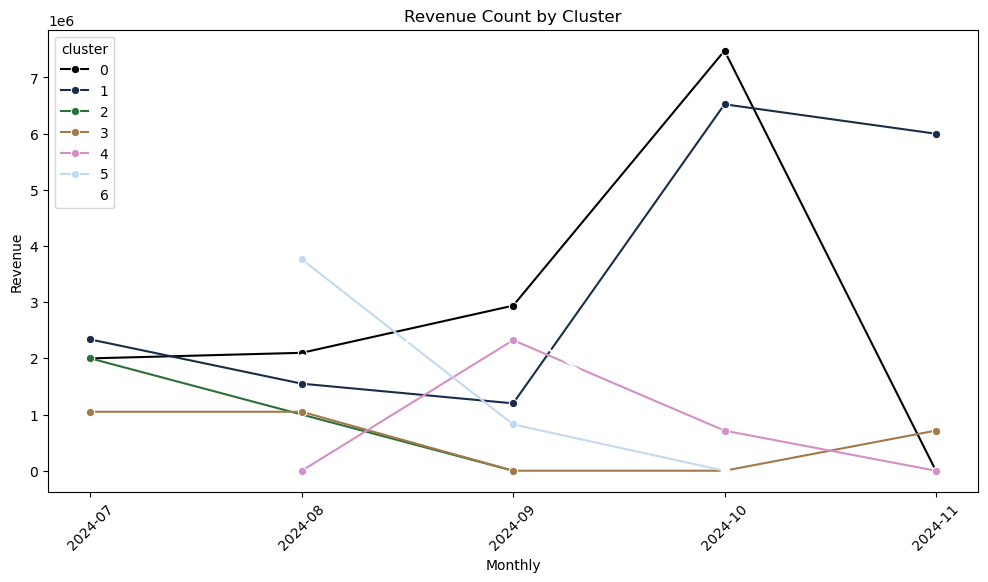

In [20]:
# Tambahkan kolom bulan
df_ogc_new['month'] = df_ogc_new['order_date'].dt.to_period('M').astype(str)

# Tambahkan kolom sales_count (asumsikan setiap baris adalah satu penjualan)
df_ogc_new['sales_count'] = 1

# Hitung monthly sales count dan revenue per cluster
monthly_sales = df_ogc_new.groupby(['cluster', 'month'])['sales_count'].sum().reset_index()
monthly_revenue = df_ogc_new.groupby(['cluster', 'month'])['price'].sum().reset_index(name='revenue')

# Function visualization lineplot
# def lineplot_visualization(data, x_col, y_col, hue_col, title, xlabel, ylabel):
lineplot_visualization(
    data=monthly_sales, 
    x_col='month', 
    y_col='sales_count',
    title='Monthly Sales Count by Cluster',
    hue_col='cluster',
    xlabel='Monthly',
    ylabel='Sales Count'
)

# def lineplot_visualization(data, x_col, y_col, hue_col, title, xlabel, ylabel):
lineplot_visualization(
    data=monthly_revenue, 
    x_col='month', 
    y_col='revenue',
    title='Revenue Count by Cluster',
    hue_col='cluster',
    xlabel='Monthly',
    ylabel='Revenue'
)

In [22]:
# Visualization map berdasarkan cluster dan neighbors
create_cluster_map(
        data = df_ogc_new,
       cluster_col = 'cluster', 
       id_col = 'id', 
       lat_col= 'lat', 
       lng_col= 'lng', 
       neighbors_col = 'neighbors', 
       distances_col = 'valid_distances', 
       address_col= 'address'
                  )

In [23]:
df_ogc_new.to_csv("result/order_garden_care_clustering_new.csv", index = False )